GAN Strcuture (GRU)


In [1]:
import csv
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchtext
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import json
import ast
import glob
import re
import string
import collections

torch.manual_seed(1)
glove = torchtext.vocab.GloVe(name='6B', dim=50)

c:\Users\ngche\anaconda3\envs\ailab\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# New Training

Setting HyperParameters

In [3]:
lr = 3e-2
batch_size = 12
num_epochs = 5
max_recipe_len = 100

Formatting Dataset (From Baseline)

In [4]:
patterns = [r'\'', r'\"', r'\.', r'<br \/>', r',', r'\(', r'\)', r'\!', r'\?', r'\:', r'\s+']
replacements = [' \'  ', '', ' . ', ' ', ' , ', ' ( ', ' ) ', ' ! ', ' ? ', ' ', ' ']
patterns_dict = list((re.compile(p), r) for p, r in zip(patterns, replacements))

def basic_english_normalize(line):
    line = line.lower()
    for pattern_re, replaced_str in patterns_dict:
        line = pattern_re.sub(replaced_str, line)
    return line.split()

directions_field = torchtext.data.Field(sequential=True,
                                  tokenize=basic_english_normalize,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True,
                                  init_token="<BOS>",
                                  eos_token="<EOS>")

fields = [('directions', directions_field), ('ingredients', None)]
baseline_data = torchtext.data.TabularDataset("./data/char_nlg_df.csv", "csv", fields)

directions_field.build_vocab(baseline_data)
directions_field.vocab = torchtext.vocab.Vocab(directions_field.vocab.freqs, specials=['<unk>','<pad>', '<BOS>', '<EOS>', ';'])
baseline_vocab_stoi = directions_field.vocab.stoi
baseline_vocab_itos = directions_field.vocab.itos
baseline_vocab_size = len(directions_field.vocab.itos)
print(baseline_vocab_size)
print(directions_field.vocab.itos)

# make data fields for ingredients
ingredients_field = torchtext.data.Field(sequential=True,
                                  tokenize=basic_english_normalize,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True,
                                  init_token="<BOS>",
                                  eos_token="<EOS>")
ing_fields = [('directions', None), ('ingredients', ingredients_field)]
ingredients_data = torchtext.data.TabularDataset("./data/char_nlg_df.csv", "csv", ing_fields)
ingredients_field.build_vocab(baseline_data)
ingredients_field.vocab = torchtext.vocab.Vocab(directions_field.vocab.freqs, specials=['<unk>','<pad>', '<BOS>', '<EOS>', ';'])
ingredients_vocab_stoi = ingredients_field.vocab.stoi
ingredients_vocab_itos = ingredients_field.vocab.itos
ingredients_vocab_size = len(ingredients_field.vocab.itos)
print(ingredients_vocab_size)
print(ingredients_field.vocab.itos)

3502
['<unk>', '<pad>', '<BOS>', '<EOS>', ';', 'and', 'in', 'to', 'add', 'with', 'minutes', 'until', 'a', 'mix', 'for', '1', 'the', 'bake', 'at', 'of', 'into', '2', 'on', 'ingredients', 'sugar', 'over', 'or', 'pour', 'stir', 'pan', 'mixture', '350', 'well', 'cook', 'butter', 'cheese', 'heat', 'water', 'together', 'top', 'inch', 'combine', 'salt', 'flour', 'cream', 'all', 'place', 'oven', 'bowl', 'brown', 'cool', 'milk', 'beat', 'baking', 'x', '4', '3', 'chicken', 'eggs', 'cover', 'put', 'onion', 'about', 'dish', 'sprinkle', 'pepper', 'then', 'cup', 'large', '9', 'serve', '10', 'cut', 'greased', 'drain', '30', 'remaining', 'is', 'remove', 'hours', 'boil', 'from', 'sauce', 'let', 'spread', 'hour', 'egg', 'vanilla', '8', '5', 'cake', 'oil', 'makes', 'set', '6', 'hot', '13', '20', 'nuts', '15', 'meat', 'margarine', 'dry', 'simmer', 'roll', 'stirring', 'casserole', 'medium', 'chill', 'each', 'blend', 'soup', 'juice', 'tender', 'pie', 'melt', 'layer', 'potatoes', 'skillet', 'sheet', 'if', 's

In [215]:
class Discriminator(nn.Module):
    
    def __init__(self,vocab_size,hidden_size,n_layers=1):
        super(Discriminator, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(vocab_size,hidden_size,n_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size,50)
        self.fc2 = nn.Linear(50,1)
    
    def forward(self,x,hidden=None):
        recipe_list = []
        for recipe in x:
            one_recipe = []
            for word in recipe:
                word_glove = int(glove.stoi['.'])
                if baseline_vocab_itos[word] in glove.stoi:
                    word_glove = int(glove.stoi[baseline_vocab_itos[word]])
                one_recipe.append( self.emb(torch.LongTensor([word_glove]))[0] )
            one_recipe_stack = torch.stack(one_recipe)
            recipe_list.append(one_recipe_stack)
        recipe_stack = torch.stack(recipe_list)
        #print(recipe_stack.shape)
        
        x = recipe_stack
        hidden = ( torch.zeros(1, x.size(0), self.hidden_size), torch.zeros(1, x.size(0), self.hidden_size) )
        out, hidden = self.rnn(x, hidden)
        #print(out.shape)
        #print(hidden[0][-1].shape)
        out = hidden[0][-1]
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        #print(out.shape)
        return torch.sigmoid(out)

class Generator(nn.Module):

    def __init__(self,vocab_size,hidden_size,n_layers=1):
        super(Generator, self).__init__()
        self.emb = torch.eye(vocab_size)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(vocab_size,hidden_size,n_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size,vocab_size)

    def forward(self, x, hidden = None):
        x = self.emb[x]
        if hidden == None:
            hidden = ( torch.zeros(1, x.size(0), self.hidden_size), torch.zeros(1, x.size(0), self.hidden_size) )
        out, hidden = self.rnn(x,hidden)
        out = self.fc1(out)
        return out, hidden

In [5]:
def sample_sequence(model, max_len=1000, temperature=0.8, prior=None):
    generated_sequence = ""
    
    inp = torch.Tensor([baseline_vocab_stoi["<BOS>"]]).long()
    hidden = None
    step = 1

    for c in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        if prior != None:
            output_dist = output_dist * prior
        top = int(torch.multinomial(output_dist, 1)[0])

        predicted_char = baseline_vocab_itos[top]

        if predicted_char == "<pad>":
            continue
        if predicted_char == "<BOS>":
            continue
        if predicted_char == "<unk>":
            continue
        if predicted_char == ";":
            step += 1
            predicted_char = str("\n" + str(step) + ".")
        if predicted_char == "<EOS>":
            break

        generated_sequence += predicted_char + " "
        inp = torch.Tensor([top]).long()

    return generated_sequence

### CURRENT VERSION

In [188]:
def train_GAN(discriminator, generator, data, lr, batch_size, num_epochs, max_recipe_len, temperature, prior=None):
    d_optimizer = optim.Adam(discriminator.parameters(), lr)
    g_optimizer = optim.Adam(generator.parameters(), lr)
    criterion = nn.BCELoss()
    iter = 0
  
    data_iter = torchtext.data.BucketIterator(data, batch_size=batch_size, sort_key=lambda x: len(x.directions), sort_within_batch=True)
    g_losses, d_losses, d_real_losses, d_fake_losses, samples = [],[],[],[],[]

    print(len(data_iter))

    for epoch in range(num_epochs):
        avg_loss = 0
        min_loss = float('inf')

        for (directions, lengths), ingredients in data_iter:
            target = directions[:, 1:]
            inp = directions[:, :-1]
            
            # Zero the gradients
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            # -------- Training the Generator ---------#
            
            # Generate a fake recipe
            word = torch.Tensor([baseline_vocab_stoi["<BOS>"]]).long()
            hidden = None
            fake_recipe = torch.empty((batch_size, max_recipe_len)).fill_(baseline_vocab_stoi['<pad>'])
            
            for b in range(batch_size):
                for c in range(max_recipe_len - 1):
                    output, hidden = generator(word.unsqueeze(0), hidden)
                    output_dist = output.data.view(-1).div(temperature).exp()
                    if prior != None:
                        output_dist = output_dist * prior
                    top = int(torch.multinomial(output_dist, 1)[0])
                    fake_recipe[b,c] = top
                    word = torch.Tensor([top]).long()
                    
                    # If we reach an 'EOS', stop the tensor here and shorten it.\n",
                    if (fake_recipe[b,c] == baseline_vocab_stoi["<EOS>"]):
                        break
                    if (c == max_recipe_len - 2):
                        fake_recipe[b,c+1] = baseline_vocab_stoi["<EOS>"]
            fake_recipe = fake_recipe.long()

            # Get the discriminator to make a prediction on whether the generated recipe is real or fake
            #D_fake = discriminator(fake_recipe, None)
            D_fake = discriminator(fake_recipe, None)

            # Calculate the loss for the generator
            labels = torch.ones_like(D_fake)
            g_loss = criterion(D_fake,labels)
            g_loss.backward()
            g_optimizer.step()

            # -------- Training the Discriminator  ---------#
            # Discriminator losses on real recipes
            D_real = discriminator(inp, None)
            labels = torch.ones_like(D_real)
            d_real_loss = criterion(D_real, labels)

            # Discriminator losses on fake recipes
            word = torch.Tensor([baseline_vocab_stoi["<BOS>"]]).long()
            hidden = None
            fake_recipe = torch.empty((batch_size, max_recipe_len)).fill_(baseline_vocab_stoi['<pad>'])

            for b in range(batch_size):
                for c in range(max_recipe_len - 1):
                    output, hidden = generator(word.unsqueeze(0), hidden)
                    output_dist = output.data.view(-1).div(temperature).exp()
                    if prior != None:
                        output_dist = output_dist * prior
                    top = int(torch.multinomial(output_dist, 1)[0])
                    fake_recipe[b,c] = top
                    word = torch.Tensor([top]).long()
                    # If we reach an 'EOS', stop the tensor here and shorten it.\n",
                    if (fake_recipe[b,c] == baseline_vocab_stoi["<EOS>"]):
                        break
                    if (c == max_recipe_len - 2):
                        fake_recipe[b,c+1] = baseline_vocab_stoi["<EOS>"]
            fake_recipe = fake_recipe.long()
            
            D_fake = discriminator(fake_recipe, None)
            labels = torch.zeros_like(D_fake)
            d_fake_loss = criterion(D_fake, labels)

            # Add up the losses and update parameters
            d_loss = 0.5 * (d_fake_loss + d_real_loss)
            d_loss.backward()
            d_optimizer.step()

            g_losses.append(float(g_loss))
            d_losses.append(float(d_loss))
            d_real_losses.append(float(d_real_loss))
            d_fake_losses.append(float(d_fake_loss))
            samples.append(iter)

            iter += 1
            if iter % 10 == 0:
                print("----Iteration # %d: g_loss %f, d_loss %f" % (iter+1, g_loss, d_loss))
                print("1. " + sample_sequence(generator, max_recipe_len, temperature, prior))

    plt.title("Generator Loss")
    plt.plot(samples, g_losses, label = "gen")
    plt.xlabel("Iterations")
    plt.ylabel("G Loss")
    plt.show()
    
    plt.title("Discriminator Loss")
    plt.plot(samples, d_real_losses, label = "real")
    plt.plot(samples, d_fake_losses, label = "fake")
    plt.plot(samples, d_losses, label = "average")
    plt.xlabel("Iterations")
    plt.ylabel("D Loss")
    plt.legend(loc='upper right')
    plt.show()

    return d_losses, g_losses

In [113]:
data_iter = torchtext.data.BucketIterator(baseline_data, batch_size=1, sort_key=lambda x: len(x.directions), sort_within_batch=True)
word_freq = collections.Counter()
    
for (directions, lengths), ingredients in data_iter:
    inp = directions[:, :-1]
    for b in range(1):
        dir_list = inp[b].tolist()
        dir_list.append(baseline_vocab_stoi['<BOS>'])
        dir_list.append(baseline_vocab_stoi['<EOS>'])
        word_freq = word_freq + collections.Counter(dir_list)
            
print(word_freq)

total = 0
for word in word_freq:
    total = total + word_freq[word]
    
print(total)

factor = 1 / total
word_prior = dict(word_freq)
for word in word_prior:
    word_prior[word] = word_prior[word] * factor

temp = {}
for key in sorted(word_prior.keys()):
  temp[key] = word_prior[key]

word_prior = temp

print({key : round(word_prior[key], 4) for key in word_prior})

word_prior_list = [0] * (max(word_prior.keys()) + 1)
for word in word_prior:
    word_prior_list[word] = word_prior[word]
    
print(word_prior_list)

Counter({4: 25142, 5: 11867, 2: 10000, 6: 6870, 3: 5000, 7: 4405, 8: 4153, 9: 3521, 10: 3363, 11: 3356, 12: 3174, 13: 3047, 14: 2942, 15: 2845, 16: 2609, 17: 2430, 18: 2308, 19: 2278, 20: 2105, 21: 2030, 22: 1847, 23: 1759, 24: 1757, 25: 1716, 26: 1711, 27: 1596, 28: 1535, 29: 1526, 30: 1485, 31: 1466, 32: 1396, 33: 1318, 34: 1255, 35: 1238, 36: 1235, 37: 1178, 38: 1175, 39: 1170, 40: 1148, 41: 1143, 42: 1141, 43: 1116, 44: 1110, 45: 990, 46: 948, 47: 915, 48: 902, 49: 884, 50: 881, 51: 879, 52: 864, 53: 853, 54: 819, 55: 810, 56: 804, 57: 774, 58: 773, 59: 759, 60: 741, 61: 730, 62: 725, 63: 725, 64: 725, 65: 723, 66: 712, 67: 707, 68: 706, 69: 701, 70: 681, 71: 680, 72: 670, 73: 651, 74: 634, 75: 630, 76: 619, 77: 617, 78: 575, 79: 572, 80: 568, 81: 568, 82: 568, 83: 565, 84: 560, 85: 559, 86: 558, 87: 555, 88: 553, 89: 549, 90: 500, 91: 494, 92: 488, 93: 470, 95: 454, 94: 454, 96: 453, 97: 453, 98: 443, 99: 442, 100: 442, 101: 438, 102: 437, 103: 428, 104: 424, 105: 423, 107: 422, 1

2500
----Iteration # 11: g_loss 0.282612, d_loss 0.814816
1. one pork 
2. egg if 
3. bottom and 
4. 
5. then stirring crisco 
6. and and soak pie cups nuts minutes dish round with chill bake by squares it divide first 15 better saute serve ahead dishes the garlic 5 vanilla over make into cook 5 combine 
----Iteration # 21: g_loss 0.316347, d_loss 0.564740
1. well mustard and of everything onion combine 
2. roll after 
3. cookie 9 cheese 
4. small coat blend 
5. remaining in cup yields cook 13 to to small cook salt and in float refrigerator pans rub beef preheat 2 
6. 
7. onion 2 salt pan in the 
----Iteration # 31: g_loss 0.316399, d_loss 0.802359
1. to for drained melt freeze and inch salt light brown 11 desired with with in and place to regular 
2. 
3. your saucepan sour drippings a and 
4. 9 8 into mixture chips 
5. boil onions 
6. by 
7. 
8. into minutes 8 and pour medium 
----Iteration # 41: g_loss 0.355498, d_loss 0.605935
1. baking 
2. baking crispy mixture cream hours applesauc

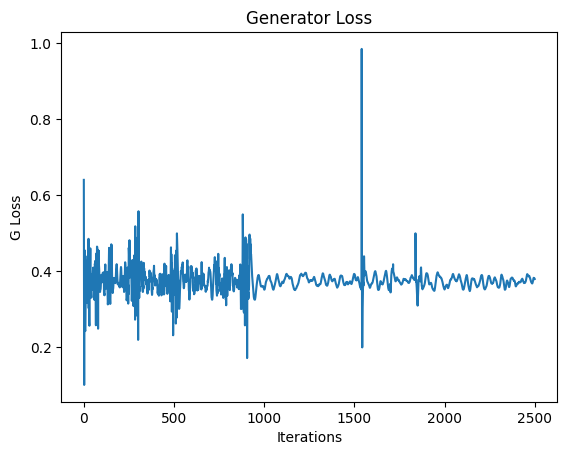

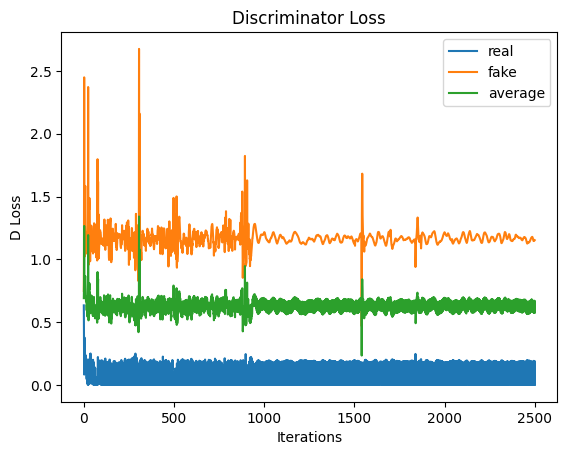

In [216]:
disc = Discriminator(50, 40, n_layers=1)
gen = Generator(baseline_vocab_size, 128, n_layers=1)
losses = train_GAN(disc, gen, baseline_data, lr=3e-2, batch_size=2, num_epochs=1, 
                   max_recipe_len=50, temperature=0.6, prior=torch.FloatTensor(word_prior_list))

In [218]:
# save model
torch.save(disc.state_dict(), "./saved_disc")
torch.save(gen.state_dict(), "./saved_gen")

In [169]:
def get_ingredient_prob(ingredient_list, prior, increased_prob=0.975, decreased_prob=0.025):
    new_prior = prior.clone().detach()
    
    new_prob = prior.sort().values[ int( prior.shape[0] * increased_prob ) ]
    
    ingredient_words = []
    for ingredient in ingredient_list:
        for word in ingredient.split(" "):
            ingredient_words.append(word)
    
    # increase probabilities of words in ingredient list
    for word in ingredient_words:
        if word in baseline_vocab_stoi:
            if prior[baseline_vocab_stoi[word]] < new_prob:
                new_prior[baseline_vocab_stoi[word]] = new_prob
         
    # decrease probabilities of ingredients not in ingredient list           
    for word in ingredients_vocab_stoi:
        if word not in ingredient_words:
            if word in baseline_vocab_stoi and word != ';' and prior[baseline_vocab_stoi[word]] < new_prob:
                new_prior[baseline_vocab_stoi[word]] = decreased_prob * prior[baseline_vocab_stoi[word]]
    
    return new_prior
    
prior = torch.FloatTensor(word_prior_list)
new_prior = get_ingredient_prob(["broccoli", "butter", "meat patty"], prior, 0.975)

print( prior[baseline_vocab_stoi["broccoli"]] )
print( new_prior[baseline_vocab_stoi["broccoli"]] )

print( prior[baseline_vocab_stoi["cheese"]] )
print( new_prior[baseline_vocab_stoi["cheese"]] )

tensor(0.0007)
tensor(0.0022)
tensor(0.0049)
tensor(0.0049)


In [219]:
disc = Discriminator(50, 40, n_layers=1)
gen = Generator(baseline_vocab_size, 128, n_layers=1)
disc.load_state_dict(torch.load("./saved_disc"))
gen.load_state_dict(torch.load("./saved_gen"))

<All keys matched successfully>

In [227]:
ingredient_list = ["broccoli", "butter", "meat patty"]

prior = torch.FloatTensor(word_prior_list)
new_prior = get_ingredient_prob(ingredient_list, prior, 0.975, 0.00)

print("1. " + sample_sequence(gen, max_recipe_len, 0.6, new_prior))

1. 
2. cut drain 1 and or pepper ingredients stir stir the sauce milk eggs remove and 
3. cover or boil cut butter 
4. baking 
5. at cover 
6. large chicken in 
7. to add to together over in into on add in drain hours and 
8. beat into in minutes cook a salt into 
9. to and heat in salt 
10. and the water 
11. to cup until the stir the of cheese until cook in add on and of ingredients minutes until cream add in 
